In [ ]:
import sys 
sys.path.append(rf"/nfs/home/genovese/thesis-wildfire-genovese/src")
from importlib import reload
import utils
reload(utils)
from utils import *
import weather_forecast_utils
reload(weather_forecast_utils)
from weather_forecast_utils import *

In [8]:
main_dir = '/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/'

In [2]:
data = pd.read_excel('/nfs/home/genovese/thesis-wildfire-genovese/data/raw/INCENDI_T_INCENDIO.xls')

In [4]:
df = separate_date(data, 'DATA_INCE')

In [ ]:
from shapely import wkt
from shapely.geometry import Point

In [ ]:
def make_point(row):
    return Point(row['WGS84EST'], row['WGS84NORD'])

df['geometry'] = df.apply(lambda x: make_point(x), axis=1)
# df['geometry'] = df['geometry'].apply(wkt.loads)

In [28]:
positives = gpd.GeoDataFrame(df, crs='EPSG:32632', geometry = 'geometry').to_crs(epsg=3857)

In [32]:
positives[positives['WGS84NORD'] < 500000]

,ID_INCENDI,ID_COMU,COD_FASCIC,DATA_INCE,LOCALITA,SUP_TOT,SUP_BOSC,SUP_NOBOSC,WGS84EST,WGS84NORD,YYYY,MM,DD,geometry
6044,6377,1147,2021_006530,2021-03-17,STRADA MOLINA,0.34,0.05,0.3,86698.0,449749.0,2021,3,17,POINT (587665.065 452374.408)


In [33]:
positives.drop(index=6044, inplace=True)

<Axes: >

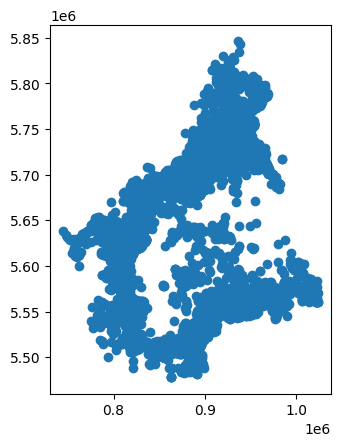

In [34]:
positives.plot()

---

In [38]:
positive_grid = positives[['ID_INCENDI', 'YYYY', 'MM', 'geometry']].rename(columns = {'ID_INCENDI': 'fire_id'})

In [39]:
positive_grid.to_file(main_dir+'database/cache/positive_grid.geojson', driver='GeoJSON', index='fire_id')

In [40]:
from shapely.geometry import Point
import random
import geopandas as gpd
from tqdm import tqdm

def create_random_point(year, min_month, max_month, fires, polygons, buffer_distance = 1000):
    month = random.randint(min_month, max_month)
    # total = 365
    # if year in list(range(2000, 2025, 4)):
    #     total += 1
    # day = random.randint(1, total)

    if not fires.shape[0] == 0:
        buffers = gpd.GeoDataFrame(gpd.GeoDataFrame(fires, geometry='geometry', crs="EPSG:3857").geometry.buffer(buffer_distance), 
                                   columns=['geometry']).union_all(method='unary')
        geometry_check = polygons.union_all(method='unary').difference(buffers)
    else:
        geometry_check = polygons.union_all(method='unary')
    
    pminx, pminy, pmaxx, pmaxy = geometry_check.bounds

    random_point = Point(random.uniform(pminx, pmaxx), random.uniform(pminy, pmaxy))
    while not geometry_check.contains(random_point):
        random_point = Point(random.uniform(pminx, pmaxx), random.uniform(pminy, pmaxy))

    return gpd.GeoDataFrame({'YYYY': {0:year}, 'MM': {0:month}, 'geometry': {0:random_point}}, crs="EPSG:3857")

In [ ]:
for y, year_df in positive_grid.groupby('YYYY'):
    winter = year_df[year_df.MM.isin([1,2,3])]
    spring = year_df[year_df.MM.isin([4,5,6])]
    summer = year_df[year_df.MM.isin([7,8,9])]
    autumn = year_df[year_df.MM.isin([10,11,12])]
    for season, season_df in zip([], [winter, spring, summer, autumn]):
        n_points = season_df.shape[0]
        negative_grid = gpd.GeoDataFrame()
        for _ in tqdm(range(n_points)):
            negative_grid = pd.concat([negative_grid, create_random_point(y, 
                                                                        season_df.MM.unique().min(), 
                                                                        season_df.MM.unique().max(), 
                                                                        positive_grid, 
                                                                        confini)], 
                                                                        ignore_index=True)

        save_clean_data(negative_grid, f'{y}_{season}_negative', main_dir+'database/cache/by_season/')
        save_clean_data(season_df, f'{y}_{season}_positive', main_dir+'database/cache/by_season/')
